# CellMap for hippocampus cell data

The tutorial for hippocampus cell data ([La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6)).

## Regular procedure

In [1]:
import cellmap
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy

The dataset is installed using the [scvelo](https://scvelo.readthedocs.io/en/stable/) package. 

In [2]:
import scvelo as scv
adata = scv.datasets.dentategyrus_lamanno()
adata

AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Preprocessing the raw data

In [3]:
scanpy.pp.log1p(adata)

Compute velocity and show the stream on UMAP. 

In [4]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata,mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: spliced, unspliced.
computing neighbors


2023-03-31 13:28:04.671691: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 13:28:04.673619: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 13:28:04.709505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 13:28:04.711280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 13:28:05.698996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

    finished (0:00:33) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:31) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:01:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:04:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


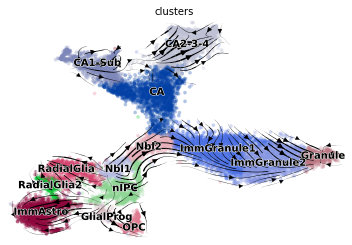

In [5]:
scv.pl.velocity_embedding_stream(adata)

In [9]:
%%time
import cellmap

cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne', alpha=0.1)

CPU times: user 40min 4s, sys: 2min 10s, total: 42min 14s
Wall time: 8min 10s


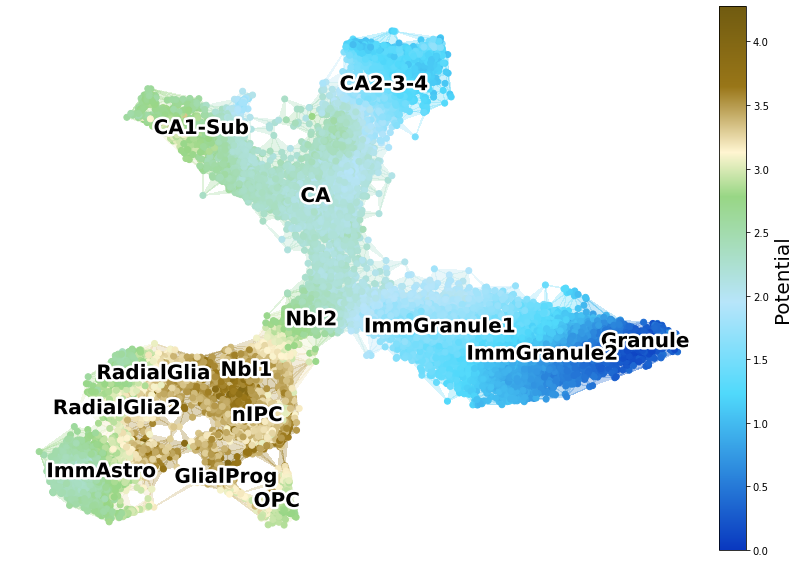

In [12]:
cellmap.view(adata, basis='X_tsne', show_graph = True, cluster_key = 'clusters')

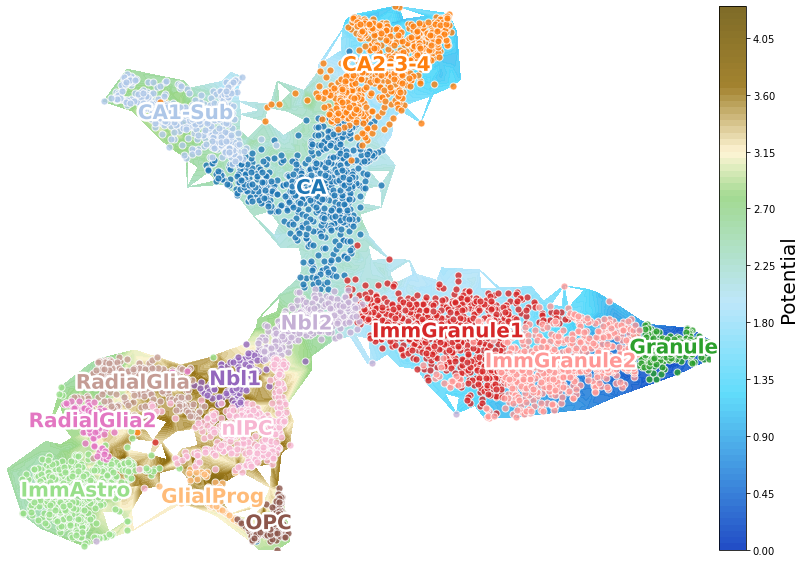

In [14]:
cellmap.view_cluster(adata, basis='X_tsne', show_graph=True, cluster_key='clusters', s=50)

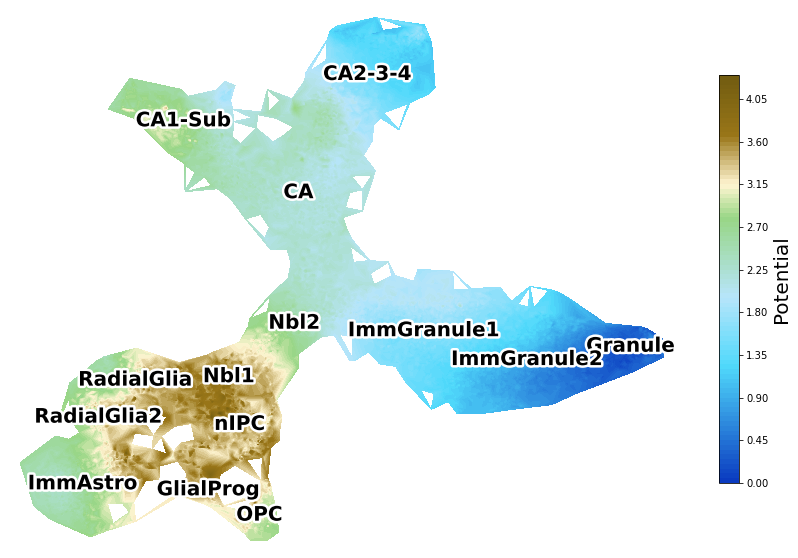

In [16]:
cellmap.view_surface(adata, basis='X_tsne', cluster_key ='clusters')

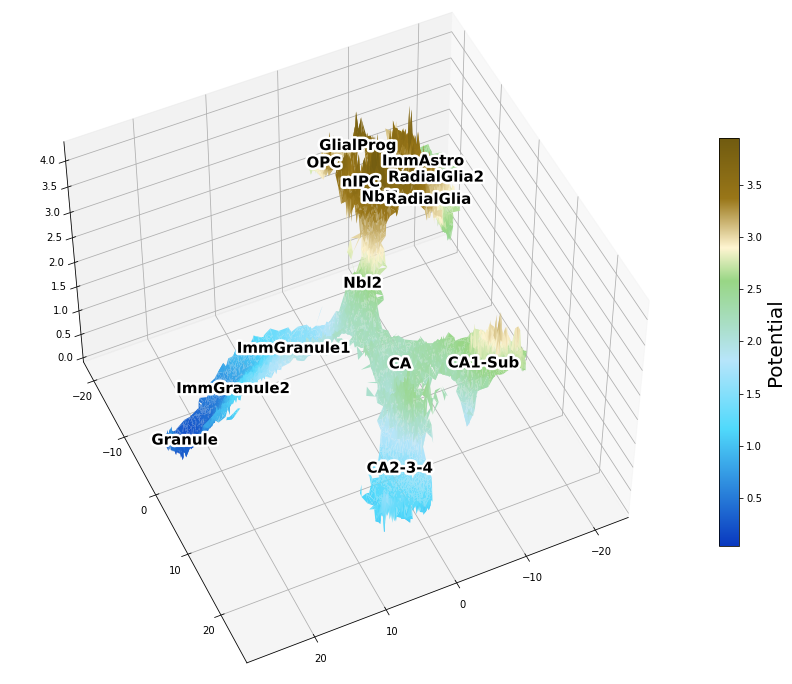

In [19]:
cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters', elev=50, azim=65)

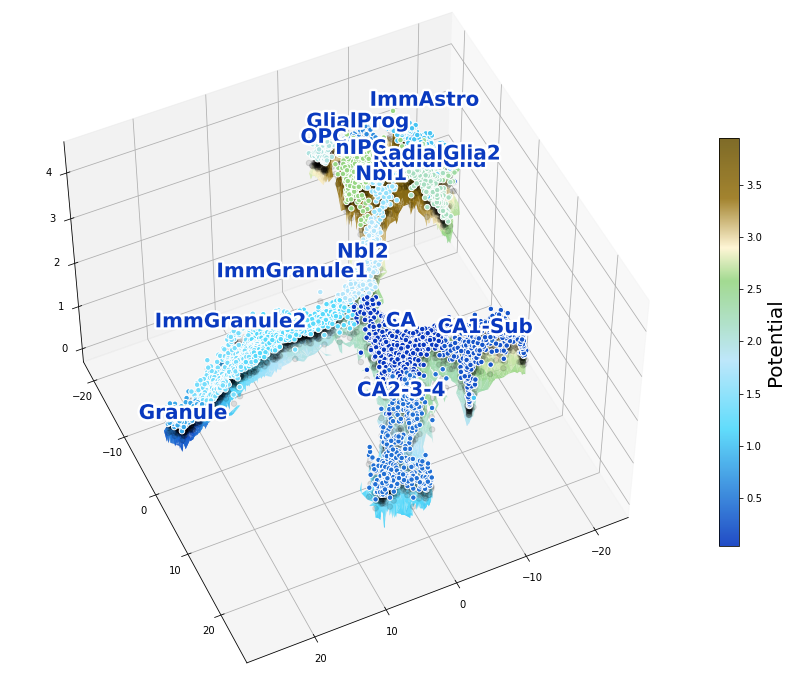

In [20]:
cellmap.view_surface_3D_cluster(adata, basis='X_tsne', cluster_key ='clusters',elev=50,azim=65,s=30);

### Write expression and potential data as CSV file for **[CellMap viewer](https://github.com/yusuke-imoto-lab/CellMapViewer)**. 

In [ ]:
cellmap.write(adata, basis='X_tsne', filename='CellMap_tutorial_hippocampus',genes=['Aqp4','Aldoc','Cdk1','Mki67','Eomes','Neurod2'])

## Changing parameter $\alpha$

The parameter $\alpha$ adjust the rate of original/reduced dimensional information of gene expression and velocity. 

$\alpha=0$ uses only two-dimensional inormation; in contrast, $\alpha=1$ uses the original (non-dimensionaly reduction) information. 

In [ ]:
alpha_set = [0,0.5,1]
for alpha in alpha_set:
    cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne',potential_key='Hodge_potential_%0.1f' % alpha,alpha=alpha)
adata

In [ ]:
for alpha in alpha_set:
    cellmap.view(adata, basis='X_tsne', show_graph = True, potential_key='Hodge_potential_%0.1f' % alpha,cluster_key='clusters',title='alpha=%0.1f' % alpha)

In [ ]:
for alpha in alpha_set:
    cellmap.view_surface_3D(adata,cluster_key ='clusters',potential_key='Hodge_potential_%0.1f' % alpha,elev=50,azim=65,title='alpha=%0.1f' % alpha), exp_2d_key = 'X_tsne', vel_2d_key='velocity_tsne'